### Imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import gpytorch as gp

from IPython.display import clear_output
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
from scipy.stats import skewnorm
from scipy.interpolate import CubicSpline

from typing import List

import warnings
warnings.filterwarnings('ignore')

### Plotting utilities

In [2]:
# set plotting hyperparameters

# set font sizes
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

# set linewidths and tick linewidths
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2

# increase tick length
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8

# increase plot line widths
plt.rcParams['lines.linewidth'] = 2

# increase marker sizes
plt.rcParams['lines.markersize'] = 8

# set colors
colors = ['#002147', '#15616D', '#E2C044', '#DE1F1F']

In [3]:
blue_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#002147", "#ffffff"])

def truncate_colormap(
        cmap: matplotlib.colors.Colormap,
        min_val: float = 0.0,
        max_val: float = 1.0,
        n: int = 256,
):
    """
    Truncate a colormap to a specified range.

    Args:
        cmap (matplotlib.colors.Colormap): The colormap to be truncated.
        min_val (float, optional): The minimum value of the colormap range. Defaults to 0.0.
        max_val (float, optional): The maximum value of the colormap range. Defaults to 1.0.
        n (int, optional): The number of colors in the truncated colormap. Defaults to 256.

    Returns:
        matplotlib.colors.Colormap: The truncated colormap.

    Raises:
        None

    Examples:
        # Truncate the 'viridis' colormap to the range [0.2, 0.8] with 128 colors
        new_cmap = truncate_colormap(plt.cm.viridis, min_val=0.2, max_val=0.8, n=128)
    """
    new_cmap = LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{min_val:.2f},{max_val:.2f})",
        cmap(np.linspace(min_val, max_val, n))
    )
    return new_cmap

# Truncate the colormap
blue_cmap = truncate_colormap(blue_cmap, 0., 0.8)

### GP models

In [4]:
# GP model for input data generation

class GPModel(gp.models.ExactGP):
    """
    Gaussian Process model for exact inference.

    Args:
        kernel (gpytorch.kernels.Kernel): The covariance kernel for the GP model.

    Attributes:
        mean_module (gpytorch.means.Mean): The mean module for the GP model.
        covar_module (gpytorch.kernels.Kernel): The covariance module for the GP model.

    """

    def __init__(
            self,
            kernel: gp.kernels.Kernel,
    ):
        """
        Initialize the GPModel.

        Args:
            kernel (gpytorch.kernels.Kernel): The covariance kernel for the GP model.

        """
        # No training data, so pass dummy tensors with shape (1, 1)
        super(GPModel, self).__init__(torch.zeros(1, 1), torch.zeros(1, 1), gp.likelihoods.GaussianLikelihood())
        self.mean_module = gp.means.ZeroMean()
        self.covar_module = kernel

    def forward(
            self,
            x: torch.Tensor,
    ):
        """
        Forward pass of the GPModel.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            gpytorch.distributions.MultivariateNormal: The output distribution.

        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
# GP model for velocity model fusion

class ApproximateGPModel(gp.models.ApproximateGP):
    """
    Approximate Gaussian Process model for variational inference.

    Args:
        inducing_points (torch.Tensor): The inducing points for the variational distribution.

    Attributes:
        mean_module (gpytorch.means.Mean): The mean module for the GP model.
        covar_module (gpytorch.kernels.Kernel): The covariance module for the GP model.

    """

    def __init__(
            self,
            inducing_points: torch.Tensor,
            kernel: gp.kernels.Kernel,
    ):
        """
        Initialize the ApproximateGPModel.

        Args:
            inducing_points (torch.Tensor): The inducing points for the variational distribution.

        """
        variational_distribution = gp.variational.CholeskyVariationalDistribution(
            inducing_points.size(-1)
        )
        variational_strategy = gp.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )
        super().__init__(variational_strategy)
        self.mean_module = gp.means.ConstantMean()
        self.covar_module = gp.kernels.ScaleKernel(kernel)

    def forward(
            self,
            x: torch.Tensor,
    ):
        """
        Forward pass of the ApproximateGPModel.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            gpytorch.distributions.MultivariateNormal: The output distribution.

        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, covar_x)

### Data generation utilities

In [6]:
def sample_gp_prior(
        kernel: gp.kernels.Kernel,
        lengthscale: float,
        n_samples: int = 1,
        x: torch.Tensor = None,
        x_samples: List[torch.Tensor] = None,
):
    """
    Generate samples from a Gaussian Process (GP) prior.

    Parameters:
    - kernel (gpytorch.kernels.Kernel): The kernel function used in the GP model.
    - lengthscale (float or List[float]): The lengthscale(s) of the kernel function. If a single value is provided, it will be used for all samples. If a list is provided, the lengthscale should match the number of samples.
    - n_samples (int): The number of samples to generate from the GP prior. Default is 1.
    - x (torch.Tensor): The input tensor for the GP model. Either `x` or `x_samples` must be specified.
    - x_samples (List[torch.Tensor]): The input tensors for each sample. If not specified, `x` will be used for all samples. The length of `x_samples` should match the number of samples.

    Returns:
    - samples (torch.Tensor): The generated samples from the GP prior.
    
    """
    ...
    if isinstance(lengthscale, (int, float)):
        lengthscale = [lengthscale] * n_samples
    elif len(lengthscale) != n_samples:
        raise ValueError("Number of length scales should match the number of samples")

    if x_samples is None:
        if x is None:
            raise ValueError("Either x or x_samples must be specified")
        x_samples = [x] * n_samples
    elif len(x_samples) != n_samples:
        raise ValueError("Number of x-arrays should match the number of samples")

    samples = torch.Tensor([])
    for i in range(n_samples):
        # Set the GP model with the custom kernel and length scale
        kernel.lengthscale = torch.tensor([lengthscale[i]])
        model = GPModel(kernel)

        # Set the model in eval mode
        model.eval()

        # Sample from the GP model
        with torch.no_grad():
            sample = model(x_samples[i]).rsample()
            samples = torch.cat([samples, sample.unsqueeze(0)], dim=0)

    return samples

In [7]:
def normalise(
        data: torch.Tensor,
        n: float,
        m: float,
):
    """
    Normalizes the given data to a specified range.

    Args:
        data (torch.Tensor): The input data to be normalized.
        n (float): The lower bound of the desired range.
        m (float): The upper bound of the desired range.

    Returns:
        torch.Tensor: The normalized data.

    """

    data = (data - torch.min(data)) / (torch.max(data) - torch.min(data))
    data = data * (m - n) + n

    return data

## Workflow

### Input data generation

In [8]:
def set_seed(seed):

    torch.manual_seed(seed)
    np.random.seed(seed)

    
seed = 0
set_seed(seed)

In [9]:
domain_size = 4
n_points = 25   # number of data points per input velocity model

# minimum and maximum seismic wave speeds in arbitrary units
min_velocity = 3
max_velocity = 7

In [10]:
# PARAMETERS TO CHANGE

DATA_GENERATION_KERNEL = gp.kernels.RBFKernel()
SVGP_FITTING_KERNEL = gp.kernels.RBFKernel()
PPGPR_FITTING_KERNEL = gp.kernels.RBFKernel()

NUM_INDUCING_POINTS = 20
LEARNING_RATE = 0.05
TRAINING_ITERATIONS = 4000

NUM_VMODEL_SAMPLES = 200

num_test_points = 201
dx = domain_size / (num_test_points - 1)
courant_number = 0.6
dt = courant_number * dx / max_velocity
nt = 600

dominant_frequency = 12. / (nt * dt)
source_time = 0.5 / dominant_frequency
SRC_IDX = int(num_test_points * 2 / 3)

time = np.arange(nt) * dt

In [11]:
# create a staggered coordinate grid
# GPs can handle non-gridded data, but we use regularly spaced
# data here for simplicity

x1 = torch.linspace(0., 3.9, n_points)  # coordinates of the first input velocity model
x2 = torch.linspace(0.1, 4., n_points)  # coordinates of the second input velocity model

xs = [x1, x2]

In [12]:
n_samples = len(xs)
lengthscale = [0.6, 0.3]    # lengthscale of the kernel function for each input velocity model

# generate velocity models as samples from the GP prior
velocity_models = sample_gp_prior(DATA_GENERATION_KERNEL, lengthscale, n_samples=n_samples, x_samples=xs)

print(velocity_models.shape)

torch.Size([2, 25])


In [13]:
# second velocity model is a weighted superposition of the two GP samples
# this creates large-scale similarities and smaller-scale differences between the two models
velocity_models[1] = (1 / 3) * velocity_models[1] + (2 / 3) * velocity_models[0]

# normalise the velocity models to the desired range
velocity_models = normalise(velocity_models, min_velocity, max_velocity)

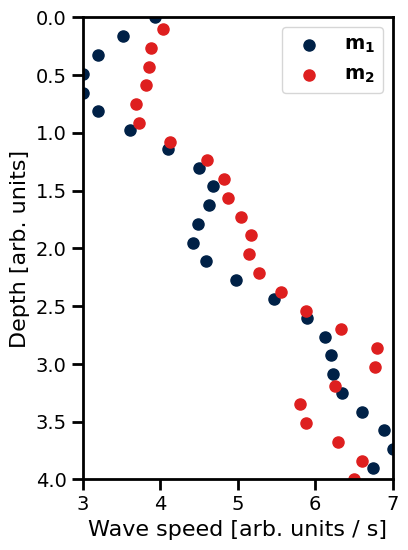

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 6))

ax.scatter(velocity_models[0], xs[0], label=r"$\bf{m}_1$", color=colors[0])
ax.scatter(velocity_models[1], xs[1], label=r"$\bf{m}_2$", color=colors[3])

ax.set(ylim=(0, 4), xlim=(min_velocity, max_velocity))
ax.set_ylabel("Depth [arb. units]")
ax.set_xlabel("Wave speed [arb. units / s]")

ax.invert_yaxis()

ax.legend()

plt.show()

### Training the models

In [15]:
# set the training data
train_x = torch.cat([x for x in xs], dim=0)
train_y = torch.cat([y for y in velocity_models], dim=0)

print(train_x.shape, train_y.shape)

torch.Size([50]) torch.Size([50])


In [16]:
# set initial locations of the inducing points
inducing_points = torch.linspace(0, 4, NUM_INDUCING_POINTS)

# initialize the SVGP and PPGPR models
ppgpr = ApproximateGPModel(inducing_points, PPGPR_FITTING_KERNEL)
svgp = ApproximateGPModel(inducing_points, SVGP_FITTING_KERNEL)

# set Gaussian likelihoods for the models
likelihood_ppgpr = gp.likelihoods.GaussianLikelihood()
likelihood_svgp = gp.likelihoods.GaussianLikelihood()

In [17]:
# # UNCOMMENT TO TRAIN THE MODEL
# ppgpr.train()
# svgp.train()
# likelihood_ppgpr.train()
# likelihood_svgp.train()

In [18]:
# # UNCOMMENT TO TRAIN THE MODEL

# # set the optimizers for the models
# optimizer_ppgpr = torch.optim.Adam([
#     {"params": ppgpr.parameters()},
#     {"params": likelihood_ppgpr.parameters()},
# ], lr=LEARNING_RATE)

# optimizer_svgp = torch.optim.Adam([
#     {"params": svgp.parameters()},
#     {"params": likelihood_svgp.parameters()},
# ], lr=LEARNING_RATE)

# # define the objective functions
# mll_ppgpr = gp.mlls.PredictiveLogLikelihood(likelihood_ppgpr, ppgpr, num_data=train_y.numel())
# mll_svgp = gp.mlls.VariationalELBO(likelihood_svgp, svgp, num_data=train_y.numel())

In [19]:
# # UNCOMMENT TO TRAIN THE MODEL
# # train the models

# for i in tqdm(range(TRAINING_ITERATIONS)):
#     optimizer_ppgpr.zero_grad()
#     output_ppgpr = ppgpr(train_x)
#     loss_ppgpr = -mll_ppgpr(output_ppgpr, train_y)
#     if i == TRAINING_ITERATIONS - 1:
#         print(f"Final PPGPR loss: {loss_ppgpr:.5f}")
#     loss_ppgpr.backward()
#     optimizer_ppgpr.step()

# for i in tqdm(range(TRAINING_ITERATIONS)):
#     optimizer_svgp.zero_grad()
#     output_svgp = svgp(train_x)
#     loss_svgp = -mll_svgp(output_svgp, train_y)
#     if i == TRAINING_ITERATIONS - 1:
#         print(f"Final SVGP loss: {loss_svgp:.5f}")
#     loss_svgp.backward()
#     optimizer_svgp.step()

In [20]:
# # UNCOMMENT IF JUST TRAINED MODEL
# # save the models and likelihoods

# torch.save(ppgpr.state_dict(), "./trained_models/ppgpr.pth")
# torch.save(svgp.state_dict(), "./trained_models/svgp.pth")

# torch.save(likelihood_ppgpr.state_dict(), "./trained_models/likelihood_ppgpr.pth")
# torch.save(likelihood_svgp.state_dict(), "./trained_models/likelihood_svgp.pth")

# load the models and likelihoods

state_dict_ppgpr = torch.load("./trained_models/ppgpr.pth")
state_dict_svgp = torch.load("./trained_models/svgp.pth")

state_dict_likelihood_ppgpr = torch.load("./trained_models/likelihood_ppgpr.pth")
state_dict_likelihood_svgp = torch.load("./trained_models/likelihood_svgp.pth")

ppgpr = ApproximateGPModel(inducing_points, PPGPR_FITTING_KERNEL)
ppgpr.load_state_dict(state_dict_ppgpr)

svgp = ApproximateGPModel(inducing_points, SVGP_FITTING_KERNEL)
svgp.load_state_dict(state_dict_svgp)

ppgpr.eval()
svgp.eval()

likelihood_ppgpr = gp.likelihoods.GaussianLikelihood()
likelihood_svgp = gp.likelihoods.GaussianLikelihood()

likelihood_ppgpr.load_state_dict(state_dict_likelihood_ppgpr)
likelihood_svgp.load_state_dict(state_dict_likelihood_svgp)

likelihood_ppgpr.eval()
likelihood_svgp.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

### Generating model predictions

In [21]:
test_x = torch.linspace(0, 4, num_test_points)   # test coordinates

# make predictions with the models
with torch.no_grad():

    observed_pred_ppgpr = ppgpr(test_x)  # produce predictions from the PPGPR latent distribution as we ignore the observation noise (latent uncertainty dominates)
    observed_pred_svgp = likelihood_svgp(svgp(test_x))  # produce predictions form the SVGP posterior predictive as the observation noise dominates the uncertainty

# extract the mean and standard deviation of the predictions

mean_ppgpr = observed_pred_ppgpr.mean
std_ppgpr = observed_pred_ppgpr.stddev

mean_svgp = observed_pred_svgp.mean
std_svgp = observed_pred_svgp.stddev

# generate samples from the predictive distributions
out_samples_ppgpr = observed_pred_ppgpr.sample(sample_shape=torch.Size([3]))
out_samples_svgp = observed_pred_svgp.sample(sample_shape=torch.Size([3]))

In [22]:
# create an array that contains the value of the predictive pdf at each depth for velocities between 2 and 8

pdf_ppgpr = torch.zeros(num_test_points, num_test_points)
pdf_svgp = torch.zeros(num_test_points, num_test_points)

test_velocities = torch.linspace(2, 8, num_test_points)

for i in range(201):

    with torch.no_grad():
        observed_pred_ppgpr = ppgpr(test_x[i].unsqueeze(0))
        observed_pred_svgp = likelihood_svgp(svgp(test_x[i].unsqueeze(0)))

    pdf_ppgpr[i, :] = 1 / (np.sqrt(2 * np.pi) * observed_pred_ppgpr.stddev) * torch.exp(-0.5 * (test_velocities - observed_pred_ppgpr.mean) ** 2 / observed_pred_ppgpr.stddev ** 2)
    pdf_svgp[i, :] = 1 / (np.sqrt(2 * np.pi) * observed_pred_svgp.stddev) * torch.exp(-0.5 * (test_velocities - observed_pred_svgp.mean) ** 2 / observed_pred_svgp.stddev ** 2)

pdf_ppgpr = pdf_ppgpr.numpy().T
pdf_svgp = pdf_svgp.numpy().T

# normalise the pdfs
pdf_ppgpr = pdf_ppgpr / np.max(pdf_ppgpr, axis=0)
pdf_svgp = pdf_svgp / np.max(pdf_svgp, axis=0)

# transform the pdfs so that the values are the distance in standard deviations from the mean
n_sigma_pdf_ppgpr = (- 2 * np.log(pdf_ppgpr)) ** 0.5
n_sigma_pdf_svgp = (- 2 * np.log(pdf_svgp)) ** 0.5

# clip the values to a maximum of 5 standard deviations, and avoid issues caused by division by zero
n_sigma_pdf_ppgpr = np.where(n_sigma_pdf_ppgpr > 5, 5, n_sigma_pdf_ppgpr)
n_sigma_pdf_svgp = np.where(n_sigma_pdf_svgp > 5, 5, n_sigma_pdf_svgp)

### Generating samples of velocity models from PPGPR predictive distribution

In [23]:
# generate many samples of velocity models from the PPGPR predictive distribution

with torch.no_grad():

    velocity_distribution = ppgpr(test_x)

velocity_samples = velocity_distribution.sample(sample_shape=torch.Size([NUM_VMODEL_SAMPLES])).numpy()

### Plotting GP fusion results

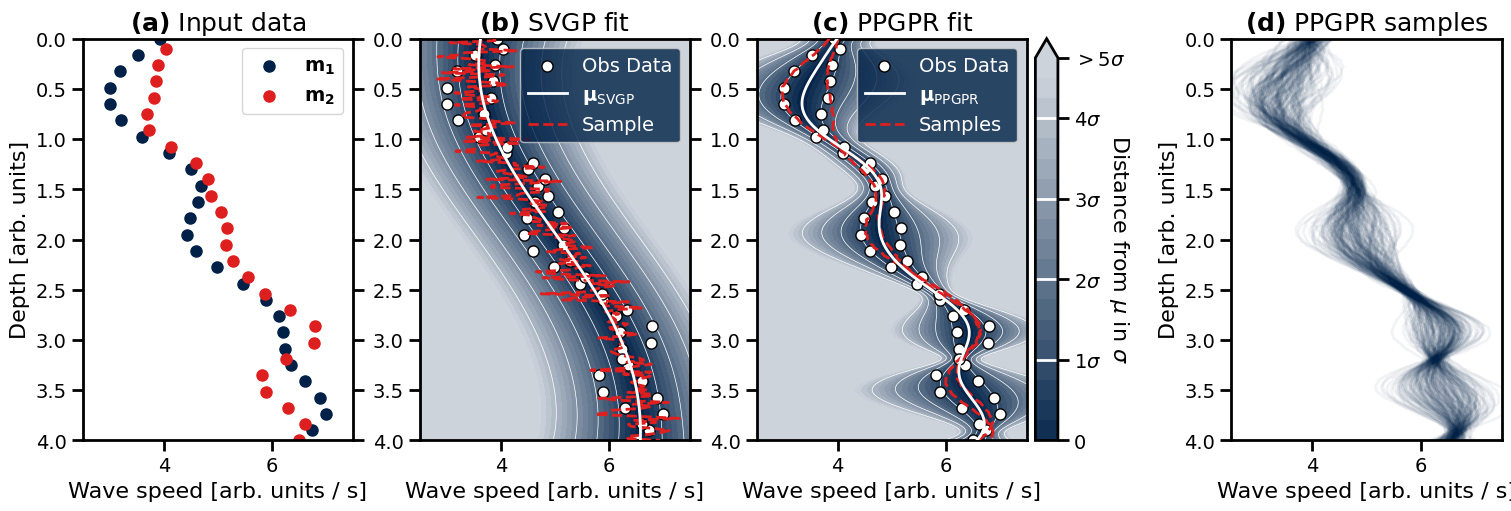

In [24]:
# plot the input data, the SVGP fit, the PPGPR fit, and the velocity samples from the PPGPR predictive distribution

gs_kw = dict(width_ratios=[12, 12, 12, 1, 0.5, 12])

fig, axs = plt.subplots(1, 6, figsize=(15, 5), constrained_layout=True, gridspec_kw=gs_kw)

for col, ax in enumerate(axs.flat):

    ax.set_xlim(2.5, 7.5)
    ax.set_ylim(0, 4)

    ax.invert_yaxis()

    if col == 0:
        ax.tick_params(right=True)

    if col == 0:
        ax.set_ylabel("Depth [arb. units]")

    if col == 1:
        ax.tick_params(right=True)

    if col != 3:
        ax.set_xlabel("Wave speed [arb. units / s]")

axs[0].scatter(velocity_models[0], xs[0], label=r"$\bf{m}_1$", color=colors[0])
axs[0].scatter(velocity_models[1], xs[1], label=r"$\bf{m}_2$", color=colors[3])

axs[0].legend(loc="upper right")

c = axs[1].contourf(test_velocities, test_x, n_sigma_pdf_svgp.T, levels=20, cmap=blue_cmap, alpha=1., zorder=0, extend="max")
axs[1].contour(test_velocities, test_x, n_sigma_pdf_svgp.T, levels=[1, 2, 3, 4], colors="white", linewidths=0.5, zorder=1)
axs[1].scatter(train_y, train_x, color="white", edgecolors="black", label="Obs Data", zorder=2)
axs[1].plot(mean_svgp, test_x, label=r"$\bf{\mu}_{\text{SVGP}}$", color="white", zorder=4)

axs[1].plot(out_samples_svgp[0], test_x, color=colors[3], ls="--", label=f"Sample", zorder=3)

axs[1].legend(facecolor=colors[0], labelcolor="white", loc="upper right")

c = axs[2].contourf(test_velocities, test_x, n_sigma_pdf_ppgpr.T, levels=20, cmap=blue_cmap, alpha=1., zorder=0, extend="max")
axs[2].contour(test_velocities, test_x, n_sigma_pdf_ppgpr.T, levels=[1, 2, 3, 4], colors="white", linewidths=0.5, zorder=1)
axs[2].scatter(train_y, train_x, color="white", edgecolors="black", label="Obs Data", zorder=2)
axs[2].plot(mean_ppgpr, test_x, label=r"$\bf{\mu}_{\text{PPGPR}}$", color="white", zorder=4)

for i in range(2):
    if i == 0:
        axs[2].plot(out_samples_ppgpr[i], test_x, color=colors[3], ls="--", label=f"Samples", zorder=3)
    else:
        axs[2].plot(out_samples_ppgpr[i], test_x, color=colors[3], ls="--", zorder=3)

axs[2].legend(facecolor=colors[0], labelcolor="white", loc="upper right")

cbar = fig.colorbar(c, cax=axs[3])
cbar.set_ticks([0, 1, 2, 3, 4, 5])
cbar.set_ticklabels([r"0", r"1$\sigma$", r"2$\sigma$", r"3$\sigma$", r"4$\sigma$", r"$>$5$\sigma$"])
cbar.set_label("Distance from $\mu$ in $\sigma$", rotation=270)

axs[3].invert_yaxis()

axs[4].axis("off")

for i in range(1, 5):
    cbar.ax.axhline(i, color="white", lw=2)

for i in range(NUM_VMODEL_SAMPLES):
    axs[5].plot(velocity_samples[i], np.linspace(0, 4, num_test_points), color=colors[0], alpha=0.05)

axs[5].set_ylabel("Depth [arb. units]")

axs[0].set_title(r"$\bf{(a)}$ Input data")
axs[1].set_title(r"$\bf{(b)}$ SVGP fit")
axs[2].set_title(r"$\bf{(c)}$ PPGPR fit")
axs[5].set_title(r"$\bf{(d)}$ PPGPR samples")

plt.show()

### Wave propagation (earthquake simulations)

#### Earthquake source

In [25]:
def ricker_wavelet(
        time: float,
        frequency: float,
):
    """
    Calculates the Ricker wavelet at a given time and dominant frequency.

    Args:
        time (float): The time at which to calculate the wavelet.
        frequency (float): The dominant frequency of the wavelet.

    Returns:
        float: The value of the Ricker wavelet at the given time and frequency.
        
    """
    t = np.pi * frequency * (time - 1. / frequency)
    return (1. - 2. * t**2) * np.exp(-t**2) * 500.

# generate the source time function
source = np.zeros(nt)
for i in range(nt):
    source[i] = ricker_wavelet(i * dt - source_time, dominant_frequency)

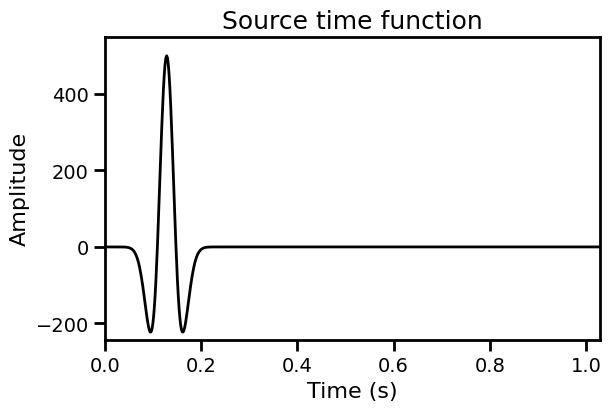

In [26]:
# plot the source time function

fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

ax.plot(time, source, color="black")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_xlim(0, nt * dt)
ax.set_ylim(np.min(source) * 1.1, np.max(source) * 1.1)
ax.set_title("Source time function")

plt.show()

#### Solving the wave equation for velocity model samples

In [27]:
from wave_propagation import pml_damping_profile, finite_difference_solver

In [28]:
num_pml_points = 25

damping = pml_damping_profile(
    num_coordinates=num_test_points,
    num_pml_points=num_pml_points,
    max_damping=20 * (1 + 2 * max_velocity / 3),
)  # PML damping profile


peak_amplitudes, plotting_wavefield = finite_difference_solver(
    velocity_models=velocity_samples,
    num_coordinates=num_test_points,
    num_time_steps=nt,
    delta_x=dx,
    delta_t=dt,
    source=source,
    source_location=SRC_IDX,
    damping=damping,
)

100%|██████████| 600/600 [00:06<00:00, 90.33it/s]


#### Solving wave equation for input velocity models

In [29]:
interpolated_models = np.zeros((2, num_test_points))

for i in range(2):
    cs = CubicSpline(xs[i], velocity_models[i])
    interpolated_models[i] = cs(np.linspace(0, 4, num_test_points))

peak_amplitudes_input_models, plotting_wavefield_input_models = finite_difference_solver(
    velocity_models=interpolated_models,
    num_coordinates=num_test_points,
    num_time_steps=nt,
    delta_x=dx,
    delta_t=dt,
    source=source,
    source_location=SRC_IDX,
    damping=damping,
)

100%|██████████| 600/600 [00:04<00:00, 133.06it/s]


### Calculating probabilistic estimate of peak ground motion and plotting

In [30]:
# statistics of the PGD distribution

median = np.median(peak_amplitudes[:, -1])

# calculate the middle 70% of the PGD
lower_bound = np.percentile(peak_amplitudes[:, -1], 15)
upper_bound = np.percentile(peak_amplitudes[:, -1], 85)

d_med_lower = median - lower_bound
d_upper_med = upper_bound - median

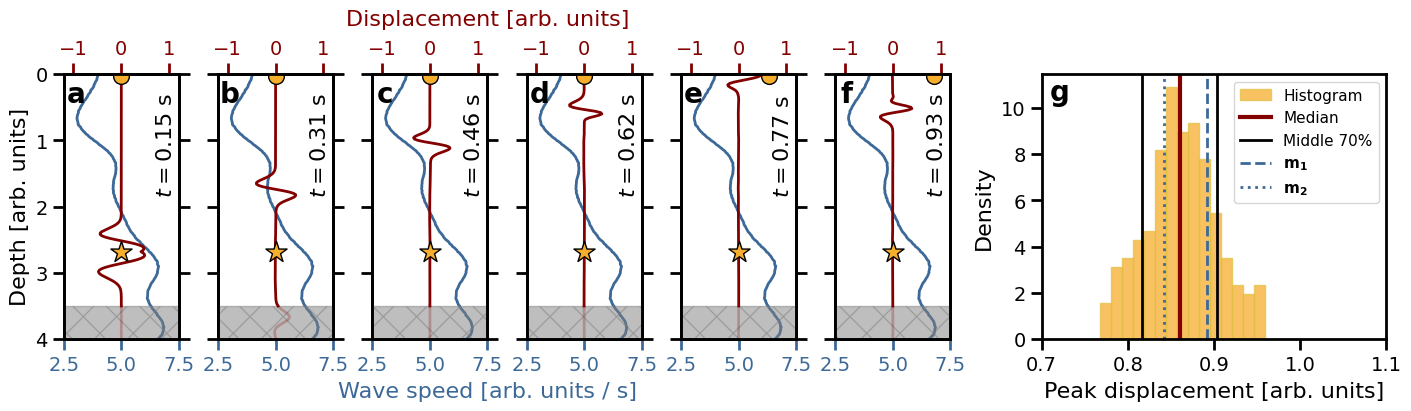

In [33]:
x = np.linspace(0., 4., num_test_points)

gs_kw = dict(width_ratios=[3, 3, 3, 3, 3, 3, 9])

fig, axs = plt.subplots(1, 7, figsize=(14, 4), constrained_layout=True, gridspec_kw=gs_kw)

for col, ax in enumerate(axs.flat[:-1]):

    ax.set_xlim(2.5, 7.5)
    ax.set_ylim(0, 4)

    ax.invert_yaxis()

    ax2 = ax.twiny()

    ax2.set_xlim(-1.2, 1.2)

    if col == 5:
        pass
    else:
        ax.tick_params(right=True)

    if col == 0:
        ax.set_ylabel("Depth [arb. units]")

    if col == 2:
        ax2.set_xlabel("Displacement [arb. units]", color="#830000", labelpad=10, x=1)
        ax.set_xlabel("Wave speed [arb. units / s]", color="#3C6997", labelpad=5, x=1)

    if col != 0:
        ax.set_yticklabels([])

    ax.tick_params(axis='x', labelcolor="#3C6997", color="#3C6997")
    ax2.tick_params(axis='x', labelcolor="#830000", color="#830000")

    N = 90

    ax.text(0.8, 0.55, f"$t = {N * (1 + col) * dt:0.2f}$ s", transform=ax.transAxes, fontsize=16, rotation="vertical")

    ax2.plot(plotting_wavefield[N * (1 + col), :-num_pml_points], x[:-num_pml_points], color="#830000")
    ax2.plot(plotting_wavefield[N * (1 + col), -num_pml_points - 1:], x[-num_pml_points - 1:], color="#830000", alpha=0.25)
    ax.plot(velocity_samples[1], x, color="#3C6997")

    ax2.scatter(0, SRC_IDX * dx, color="#F6AE2D", marker="*", s=256, edgecolor="black", zorder=5)

    ax2.scatter(peak_amplitudes[1, N * (1 + col)], 0.025, color="#F6AE2D", marker="o", s=128, edgecolor="black", zorder=2)

    ax2.fill_between([-1.2, 1.2], domain_size - num_pml_points * dx, 4, color="tab:grey", alpha=0.5, hatch="x")

axs[-1].hist(peak_amplitudes[:, -1], bins=15, density=True, color="#F6AE2D", alpha=0.75, label="Histogram", edgecolor=colors[2])

axs[-1].axvline(median, color="#830000", lw=3, label="Median")
axs[-1].axvline(lower_bound, color="black", lw=2, label="Middle 70%")
axs[-1].axvline(upper_bound, color="black", lw=2)

axs[-1].axvline(peak_amplitudes_input_models[0, -1], color="#3C6997", lw=2, ls="--", label=r"$\bf{m}_1$")
axs[-1].axvline(peak_amplitudes_input_models[1, -1], color="#3C6997", lw=2, ls=":", label=r"$\bf{m}_2$")

# axs[-1].set_xlim([median - 4 * d_med_lower, median + 4.5 * d_med_upper])
axs[-1].set_xlim([0.7, 1.1])

# axs[-1].set_yticks([])
axs[-1].set_xlabel("Peak displacement [arb. units]", labelpad=5)
axs[-1].set_ylabel("Density", labelpad=5)

axs[-1].legend(fontsize=11)

lposx = 0.1
lposy = 0.925

axs[0].text(lposx, lposy, r"$\bf{a}$", transform=axs[0].transAxes, fontsize=20, ha="center", va="center")
axs[1].text(lposx, lposy, r"$\bf{b}$", transform=axs[1].transAxes, fontsize=20, ha="center", va="center")
axs[2].text(lposx, lposy, r"$\bf{c}$", transform=axs[2].transAxes, fontsize=20, ha="center", va="center")
axs[3].text(lposx, lposy, r"$\bf{d}$", transform=axs[3].transAxes, fontsize=20, ha="center", va="center")
axs[4].text(lposx, lposy, r"$\bf{e}$", transform=axs[4].transAxes, fontsize=20, ha="center", va="center")
axs[5].text(lposx, lposy, r"$\bf{f}$", transform=axs[5].transAxes, fontsize=20, ha="center", va="center")
axs[6].text(0.05, lposy, r"$\bf{g}$", transform=axs[6].transAxes, fontsize=20, ha="center", va="center")

plt.show()